# Lecture 4: Subduction

This notebook uses the data in the `data` folder and model outputs to make figures for the lecture. 

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As always, start by importing the packages that we need.

In [1]:
import gzip
import bz2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import xarray as xr
import pandas as pd
import pyproj
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import verde as vd
import harmonica as hm
import boule as bl

## Load the datasets

We'll plot a profile from several datasets seen in class. First, we'll have to load all the data.

### Topography

In [2]:
etopo1 = xr.open_dataarray("../../data/earth_relief_10m.grd").rename("topography").rename(dict(lon="longitude", lat="latitude")) * 0.001
topography = vd.grid_to_table(etopo1)
topography

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


,latitude,longitude,topography
0,-90.0,-180.000000,2.862
1,-90.0,-179.833333,2.862
2,-90.0,-179.666667,2.862
3,-90.0,-179.500000,2.862
4,-90.0,-179.333333,2.862
...,...,...,...
2336036,90.0,179.333333,-4.224
2336037,90.0,179.500000,-4.224
2336038,90.0,179.666667,-4.224
2336039,90.0,179.833333,-4.224


### Gravity

In [3]:
with bz2.open("../../data/EIGEN-6C4-gravity-30m.gdf.bz2", "rt") as decompressed:
    gravity_grid = hm.load_icgem_gdf(decompressed)
gravity_grid["disturbance"] = gravity_grid.gravity_ell - bl.WGS84.normal_gravity(gravity_grid.latitude, gravity_grid.height_over_ell)
gravity = vd.grid_to_table(gravity_grid)
gravity

,latitude,longitude,gravity_ell,height_over_ell,disturbance
0,-90.0,-180.0,980109.412790,10000.0,-32.922303
1,-90.0,-179.5,980109.412790,10000.0,-32.922303
2,-90.0,-179.0,980109.412790,10000.0,-32.922303
3,-90.0,-178.5,980109.412790,10000.0,-32.922303
4,-90.0,-178.0,980109.412790,10000.0,-32.922303
...,...,...,...,...,...
260276,90.0,178.0,980158.943918,10000.0,16.608825
260277,90.0,178.5,980158.943918,10000.0,16.608825
260278,90.0,179.0,980158.943918,10000.0,16.608825
260279,90.0,179.5,980158.943918,10000.0,16.608825


### Global seismicity catalog

In [4]:
# Use the gzip library to open the compressed file directly, like magic!
with gzip.open("../../data/jan76_dec17.ndk.gz", "rt") as quake_file:
    # Start off with an empty list and we'll populate it with quakes one at a time
    quakes = []
    # Read and iterate over the lines of the file one by one.
    # Use enumerate to get the line number as well.
    for line_number, line in enumerate(quake_file):
        # The data we want (location and depth) are only in every 5th line
        if line_number % 5 == 0:
            # The line looks like this:
            #   MLI  1976/01/01 01:29:39.6 -28.61 -177.64  59.0 6.2 0.0 KERMADEC ISLANDS REGION 
            # Split the line along spaces
            parts = line.split()
            # Unpack the location and depth into variables
            latitude, longitude, depth = [float(i) for i in parts[3:6]]
            # Add the 3 variables to the quakes list
            if depth > 70:
                quakes.append([latitude, longitude, depth])
quakes = np.array(quakes, dtype="float32")
print(quakes)

[[-13.29 -74.9   95.  ]
 [-15.76 167.87 168.  ]
 [ -7.48 119.9  614.  ]
 ...
 [-19.34 -69.43 103.3 ]
 [ 29.68 129.3  162.8 ]
 [ 17.86 145.89 156.6 ]]


## Wadati-Benioff zone

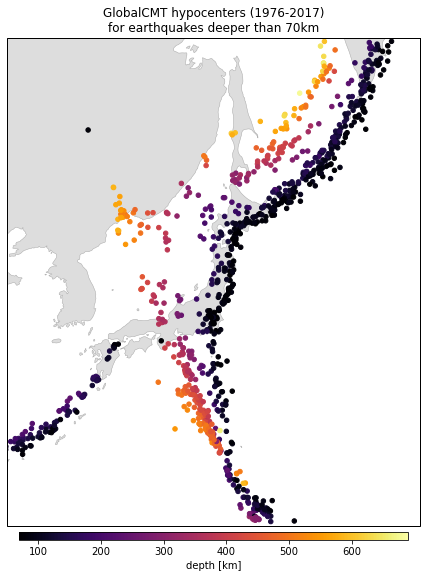

In [5]:
plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=140, central_latitude=40))
ax.set_title("GlobalCMT hypocenters (1976-2017)\nfor earthquakes deeper than 70km")
ax.set_extent((125, 155, 20, 55))
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 
        'land', 
        '50m',
        edgecolor='#aaaaaa',
        facecolor="#dddddd",
        linewidth=0.5,
    ),
    zorder=0,
)
# Scatter takes the point locations, size, and color
tmp = ax.scatter(
    quakes[:, 1], 
    quakes[:, 0], 
    s=20, 
    c=quakes[:, 2], 
    cmap="inferno", 
    transform=ccrs.PlateCarree(),
)
# Add a color bar related to the scatter we just plotted
plt.colorbar(tmp, label="depth [km]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.9)
plt.subplots_adjust(top=0.94, bottom=-0.07, right=1, left=0, hspace=0, wspace=0)
plt.savefig("japan-trench-globalcmt.png", dpi=200)
plt.show()

## Profiles

In [115]:
def make_profiles(start, end, region, projection):
    interpolator = vd.ScipyGridder(method="cubic")
    profile = []
    data_names = ["topography", "disturbance"]
    data_vars = [topography, gravity]
    for name, table in zip(data_names, data_vars):
        table = table[vd.inside((table.longitude, table.latitude), region)]
        coords = projection(table.longitude.values, table.latitude.values)
        interpolator.fit(coords, table[name])
        profile.append(
            interpolator.profile(
                start, 
                end,
                size=300, 
                projection=projection, 
                data_names=[name],
                dims=["latitude", "longitude"],
            )
        )
    profile = pd.concat(profile, axis=1)
    # Remove duplicate columns
    profile = profile.loc[:,~profile.columns.duplicated()]
    # m to km
    profile["distance"] *= 0.001
    return profile

In [116]:
def plot_profiles(profile):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
    bounds = [profile.distance.min(), profile.distance.max()]

    ax = axes[0]
    ax.plot(profile.distance, profile.disturbance, "-k")
    ax.plot(bounds, [0, 0], "--", color="gray", linewidth=1)
    ax.set_ylabel("gravity disturbance\n[mGal]")

    max_depth = -10
    ax = axes[1]
    ax.fill_between(bounds, [0, 0], max_depth, color='#bbbbbb')
    #ax.fill_between(bounds, [0, 0], max_depth, color='#629fe3')
    ax.fill_between(profile.distance, profile.topography, max_depth, color='#333333')
    ax.set_ylabel('topography/bathymetry\n[km]')
    ax.set_xlabel('Distance [km]')
    ax.set_xlim(*bounds)
    ax.set_ylim(max_depth, profile.topography.max() + 5)
    plt.tight_layout(w_pad=0, h_pad=0)
    return fig, axes

In [117]:
mariana = make_profiles(
    end=(150, 13), 
    start=(144, 15),
    region=(135, 155, 5, 20),
    projection=pyproj.Proj(proj="merc"),
)

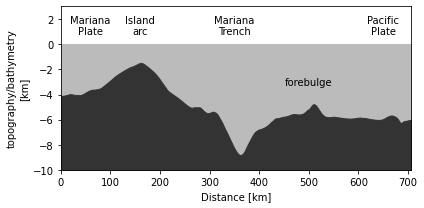

In [118]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
bounds = [mariana.distance.min(), mariana.distance.max()]
max_depth = -10
ax.fill_between(bounds, [0, 0], max_depth, color='#bbbbbb')
#ax.fill_between(bounds, [0, 0], max_depth, color='#629fe3')
ax.fill_between(mariana.distance, mariana.topography, max_depth, color='#333333')
ax.set_ylabel('topography/bathymetry\n[km]')
ax.set_xlabel('Distance [km]')
ax.set_xlim(*bounds)
ax.set_ylim(max_depth, mariana.topography.max() + 4.5)
text_args = dict(horizontalalignment='center', verticalalignment='center')
ax.text(60, 1.5, "Mariana\nPlate", **text_args)
ax.text(160, 1.5, "Island\narc", **text_args)
ax.text(350, 1.5, "Mariana\nTrench", **text_args)
ax.text(500, -3, "forebulge", **text_args)
ax.text(650, 1.5, "Pacific\nPlate", **text_args)
plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig("profiles-mariana.png", dpi=200)
plt.show()

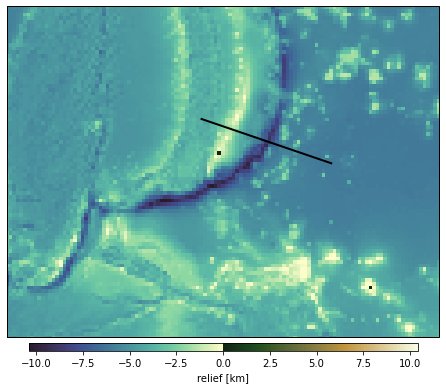

In [101]:
plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.Mercator())
etopo1.plot(
    ax=ax, 
    cmap=cmocean.cm.topo,
    transform=ccrs.PlateCarree(), 
    cbar_kwargs=dict(label="relief [km]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.9),
    zorder=0,
)
ax.coastlines()
ax.plot(
    mariana.longitude, 
    mariana.latitude,
    "-k",
    linewidth=2,
    transform=ccrs.PlateCarree(),
)
ax.set_extent((135, 155, 5, 20))
plt.subplots_adjust(top=0.94, bottom=-0.07, right=1, left=0, hspace=0, wspace=0)
plt.savefig("mariana-relief.png", dpi=200)
plt.show()

In [11]:
andes = make_profiles(
    start=(-75, -18), 
    end=(-55, -18),
    region=(-80, -50, -30, -15),
    projection=pyproj.Proj(proj="merc"),
)

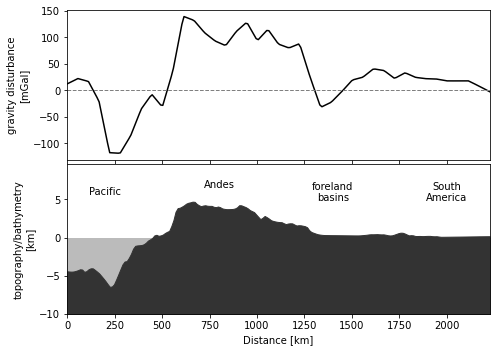

In [12]:
fig, axes = plot_profiles(andes)
text_args = dict(horizontalalignment='center', verticalalignment='center')
axes[-1].text(200, 6, "Pacific", **text_args)
axes[-1].text(800, 7, "Andes", **text_args)
axes[-1].text(1400, 6, "foreland\nbasins", **text_args)
axes[-1].text(2000, 6, "South\nAmerica", **text_args)
plt.savefig("profiles-andes.png", dpi=200)
plt.show()

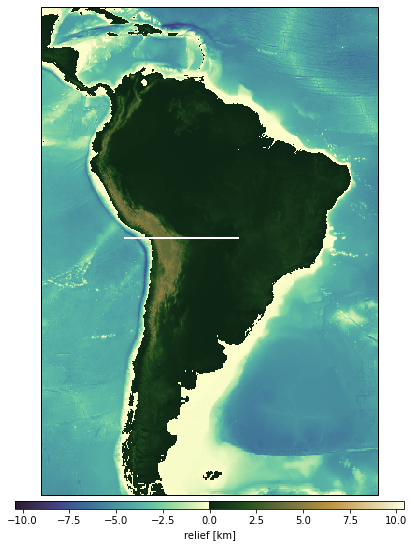

In [13]:
plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-60))
ax.set_extent((-90, -30, -50, 20))
etopo1.plot(
    ax=ax, 
    cmap=cmocean.cm.topo,
    transform=ccrs.PlateCarree(), 
    cbar_kwargs=dict(label="relief [km]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.9),
    zorder=0,
)
ax.plot(
    andes.longitude, 
    andes.latitude,
    "-w",
    linewidth=2,
    transform=ccrs.PlateCarree(),
)
plt.subplots_adjust(top=0.94, bottom=-0.07, right=1, left=0, hspace=0, wspace=0)
plt.savefig("andes-relief.png", dpi=200)
plt.show()

In [14]:
japan = make_profiles(
    end=(150, 32.5), 
    start=(130, 45),
    region=(125, 155, 20, 55),
    projection=pyproj.Proj(proj="merc"),
)

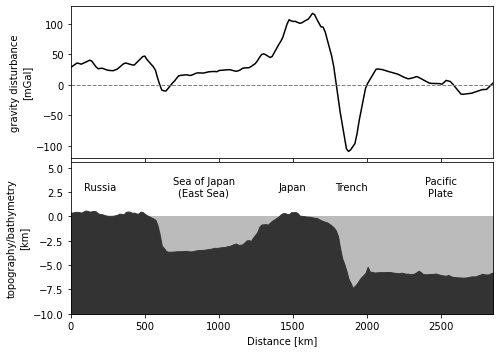

In [15]:
fig, axes = plot_profiles(japan)
text_args = dict(horizontalalignment='center', verticalalignment='center')
axes[-1].text(200, 3, "Russia", **text_args)
axes[-1].text(900, 3, "Sea of Japan\n(East Sea)", **text_args)
axes[-1].text(1500, 3, "Japan", **text_args)
axes[-1].text(1900, 3, "Trench", **text_args)
axes[-1].text(2500, 3, "Pacific\nPlate", **text_args)
plt.savefig("profiles-japan.png", dpi=200)
plt.show()

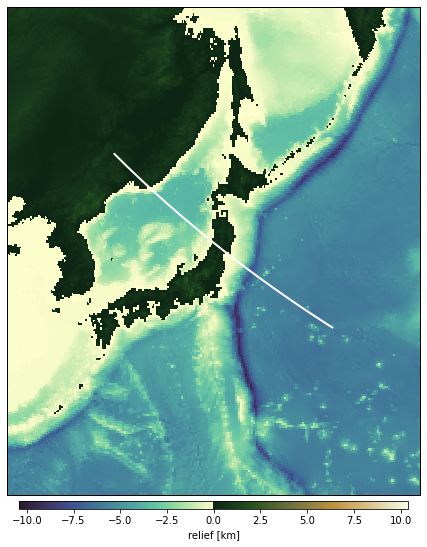

In [16]:
plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=140, central_latitude=40))
ax.set_extent((125, 155, 20, 55))
etopo1.plot(
    ax=ax, 
    cmap=cmocean.cm.topo,
    transform=ccrs.PlateCarree(), 
    cbar_kwargs=dict(label="relief [km]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.9),
    zorder=0,
)
ax.plot(
    japan.longitude, 
    japan.latitude,
    "-w",
    linewidth=2,
    transform=ccrs.PlateCarree(),
)
plt.subplots_adjust(top=0.94, bottom=-0.07, right=1, left=0, hspace=0, wspace=0)
plt.savefig("japan-relief.png", dpi=200)
plt.show()

## Flexure

In [151]:
def universal_flexure(x, x0, xforebulge):
    xscaled = (x - x0) / (xforebulge - x0)
    flexure = (
        np.exp(np.pi / 4) 
        * np.sqrt(2) 
        * np.exp(- np.pi / 4 * xscaled)
        * np.sin(np.pi / 4 * xscaled)
    )
    return xscaled, flexure

In [160]:
xscaled, flexure_nondimensional = universal_flexure(
    x=np.linspace(0, 300, 200),
    x0=100,
    xforebulge=155,
)

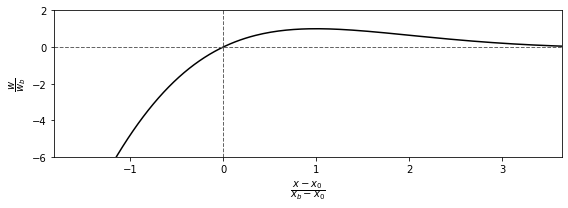

In [177]:
plt.figure(figsize=(8, 3))
plt.plot(xscaled, flexure_nondimensional, "-k", linewidth=1.5)
plt.plot([xscaled.min(), xscaled.max()], [0, 0], "--", color="#666666", linewidth=1)
plt.plot([0, 0], [-6, 2], "--", color="#666666", linewidth=1)
plt.xlabel(r"$\dfrac{x - x_0}{x_b - x_0}$")
plt.ylabel(r"$\dfrac{w}{w_b}$")
plt.xlim(xscaled.min(), xscaled.max())
plt.ylim(-6, 2)
plt.tight_layout()
plt.savefig("universal-flexure-profile.png", dpi=200)
plt.show()

In [196]:
ranges = mariana.distance > 340
scaled_topo = mariana.topography[ranges] + 6.1
scaled_distance = mariana.distance[ranges].values
scaled_distance -= scaled_distance[np.where(scaled_topo > 0)[0][0]]
x_forebulge = 55
flexure_forebulge = 0.5

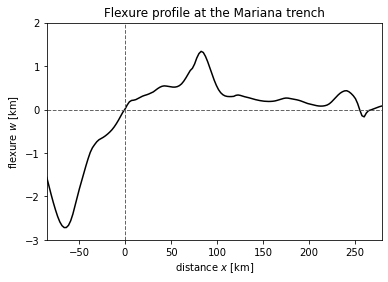

In [199]:
plt.figure(figsize=(6, 4))
plt.title("Flexure profile at the Mariana trench")
plt.plot(scaled_distance, scaled_topo, "-k", linewidth=1.5)
plt.plot([scaled_distance.min(), scaled_distance.max()], [0, 0], "--", color="#666666", linewidth=1)
plt.plot([0, 0], [-3, 2], "--", color="#666666", linewidth=1)
plt.xlabel(r"distance $x$ [km]")
plt.ylabel(r"flexure $w$ [km]")
plt.xlim(scaled_distance.min(), scaled_distance.max())
plt.ylim(-3, 2)
plt.savefig("mariana-flexure-observed.png", dpi=200)
plt.show()

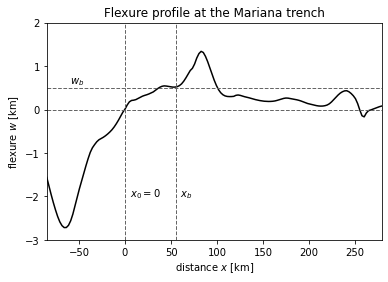

In [200]:
plt.figure(figsize=(6, 4))
plt.title("Flexure profile at the Mariana trench")
plt.plot(scaled_distance, scaled_topo, "-k", linewidth=1.5)
plt.plot([scaled_distance.min(), scaled_distance.max()], [0, 0], "--", color="#666666", linewidth=1)
plt.plot([0, 0], [-3, 2], "--", color="#666666", linewidth=1)
plt.plot([x_forebulge, x_forebulge], [-3, 2], "--", color="#666666", linewidth=1)
plt.text(5, -2, r"$x_0 = 0$")
plt.text(x_forebulge + 5, -2, r"$x_b$")
plt.plot([scaled_distance.min(), scaled_distance.max()], [flexure_forebulge, flexure_forebulge], "--", color="#666666", linewidth=1)
plt.text(-60, flexure_forebulge + 0.1, r"$w_b$")
plt.xlabel(r"distance $x$ [km]")
plt.ylabel(r"flexure $w$ [km]")
plt.xlim(scaled_distance.min(), scaled_distance.max())
plt.ylim(-3, 2)
plt.savefig("mariana-flexure-observed.png", dpi=200)
plt.show()